In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

pd.set_option("display.max_columns", None)

print('success')

2022-03-24 06:19:12.239638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:$LD_LIBRARY_PATH
2022-03-24 06:19:12.239689: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


success


### Processing images
#### Example taken from: https://www.kaggle.com/seyunhan/inceptionresnetv2-keras-pbl4

We load the train,test,val images here

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
# train['image'] = train['image']
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

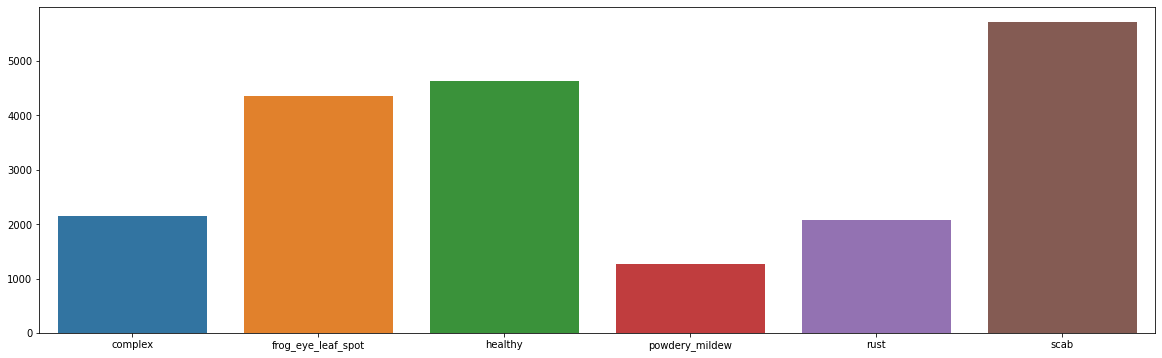

In [4]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

In [5]:
images = []

for img_name in tqdm(train['image']):
    path = './train_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((224,224))
        img.save(f'./train_images/{img_name}')
    img = cv2.imread(path)
    images.append(img)

100%|████████████████████████████████████| 18632/18632 [00:36<00:00, 515.79it/s]


In [6]:
#This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. 

images = np.array(images)

# images = images.astype('float32') / 255.0
images.shape

(18632, 224, 224, 3)

### Viewing some images

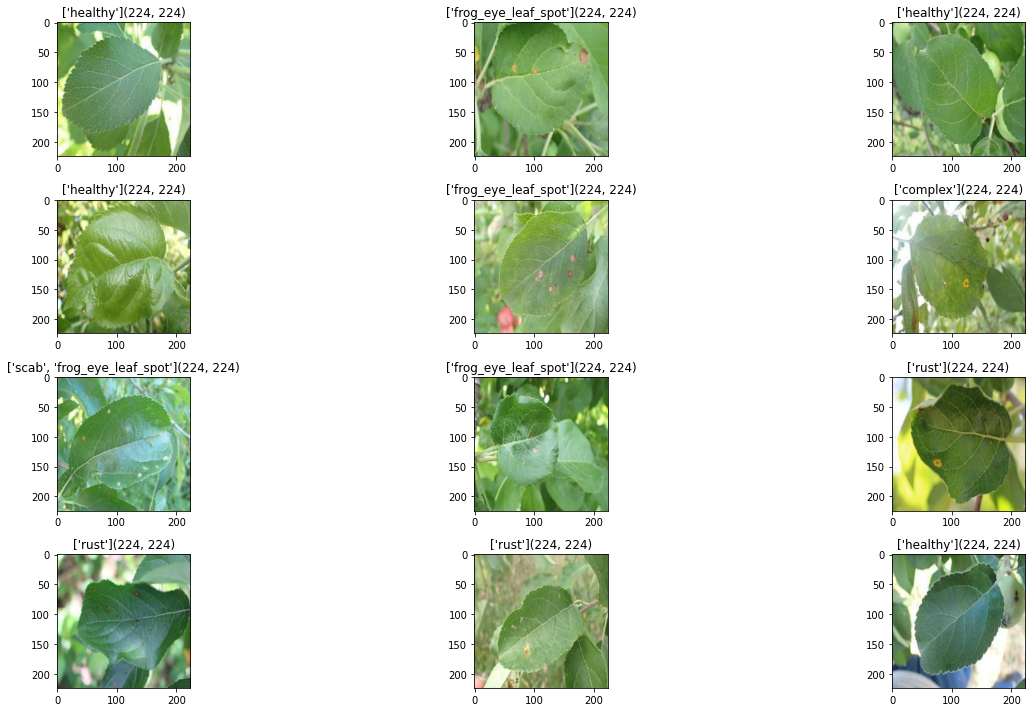

In [7]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, len(list(train['image'])))
    sample = os.path.join('./train_images/', train['image'][rand])
    
    img = Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result

col_transformer = ColumnTransformer([
    ('multi-hot', MultiHotEncoder(), ['labels'])
])
Y = col_transformer.fit_transform(train)
print(col_transformer.named_transformers_['multi-hot'].categories_)
Y

[array(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew',
       'rust', 'scab'], dtype=object)]


array([[0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0]])

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

print(Y)

images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.2, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

[[0 0 1 0 0 0]
 [1 1 0 0 0 1]
 [0 0 0 0 0 1]
 ...
 [0 0 0 0 1 0]
 [0 1 0 0 0 1]
 [0 0 1 0 0 0]]
(14905, 224, 224, 3)
(14905, 6)
(3727, 224, 224, 3)
(3727, 6)


# EfficientNetB0 Implementation Custom Dataset

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 6
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)


inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# model = keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=True, weights=None, classes=6)
# model.summary()

2022-03-24 06:20:08.179088: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-24 06:20:08.179152: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu-cpu): /proc/driver/nvidia/version does not exist
2022-03-24 06:20:08.180243: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"] )

model.summary()

hist = model.fit(train_x, train_y, epochs=60, verbose=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 6)                4057257   
                                                                 
Total params: 4,057,257
Trainable params: 4,015,234
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/60
466/466 - 815s - loss: 0.5230 - accuracy: 0.3183 - 815s/epoch - 2s/step
Epoch 2/60
466/466 - 796s - loss: 0.3881 - accuracy: 0.4392 - 796s/epoch - 2s/step
Epoch 3/60
466/466 - 1056s - loss: 0.3068 - accuracy: 0.6009 - 1056s/epoch - 2s/step
Epoch 4/60
466/466 - 1238s - loss: 0.2538 - accuracy: 0.6954 - 1238s/epoch - 3s/step
Epoch 5/60
466/466 - 1210s - loss: 0.2125 - accuracy: 0.7612 - 1210s/epoch - 3s/step
Epoch 6/60
466/466 - 

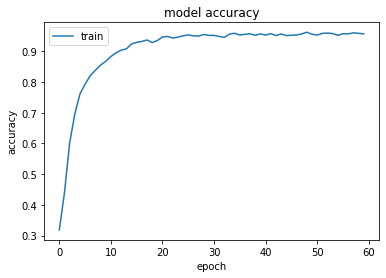

In [12]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [13]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

117/117 [==============================] - 41s 340ms/step - loss: 0.3352 - accuracy: 0.8302
Loss = 0.3351757824420929
Test Accuracy = 0.8301582932472229


# Testing Efficient Model On Unseen data

test_images/c7b03e718489f3ca.jpg
Input image shape: (1, 224, 224, 3)
[[1.7912509e-01 5.0152498e-03 5.1394278e-01 3.7129488e-04 2.9610831e-01
  5.4372884e-03]]
test_images/85f8cb619c66b863.jpg
Input image shape: (1, 224, 224, 3)
[[3.3788008e-04 3.8479677e-05 2.2454772e-04 3.9147348e-05 9.9935955e-01
  3.9011277e-07]]
test_images/ad8770db05586b59.jpg
Input image shape: (1, 224, 224, 3)
[[8.0109345e-08 3.8464589e-07 3.9690706e-01 2.6790439e-10 6.0309243e-01
  5.7392056e-12]]


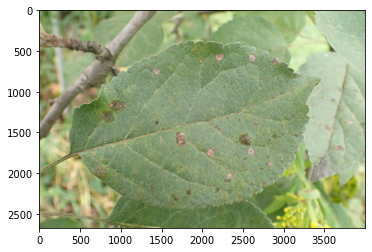

In [49]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input


path = 'test_images/'
dataset_path = os.listdir('test_images')

preds = []

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

for i in dataset_path:
    img_path = path + str(i)
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)

    print('Input image shape:', x.shape)

    my_image = imread(img_path)
    imshow(my_image)
    
    pred=model.predict(x)
    print(pred)     # probabilities for being in each of the 3 classes
    preds.append(pred.tolist()[0])

In [61]:
n_labels = 5
test = pd.read_csv('./sample_submission.csv')

# {0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
threshold = {0: 0.26, # Complex
             5: 0.61, # scab
             1: 0.7, # frog eye leaf spot
             4: 0.5, # rust
             3: 0.5, # powdery mildew
             2: 0.3} #healthy

# Can set different threshold here
indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=threshold[pred.index(category)]: #assigning a different threshold to each disease
            temp.append(pred.index(category))
    if temp!=[]:
        pass
    else:
        temp.append(np.argmax(pred))
    # only add the predicted healthy labels, remove others
    if 2 in temp:
        temp = [2] # Resets the list 
    indices.append(temp)
    
print(indices)

[[2], [4], [2]]


In [62]:
actualtestlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    actualtestlabels.append(' '.join(temp))

print(actualtestlabels)

sub = pd.read_csv('./sample_submission.csv')
sub['labels'] = actualtestlabels
sub.to_csv('submission.csv', index=False)
sub

['healthy', 'rust', 'healthy']


,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,rust
2,c7b03e718489f3ca.jpg,healthy
